In [1]:
global_parameters = {
    'quantile': [0.10, 0.25, 0.35, 0.50, 0.75, 0.80, 0.90] # 날짜별 에러 정보를 유저 아이디로 취합할 때 사용할 quantile 값
}

In [386]:
from pycaret.classification import *
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc
import random
import lightgbm as lgb
import re
from sklearn.metrics import *
from sklearn.model_selection import KFold, StratifiedKFold
import warnings
warnings.filterwarnings(action='ignore')

PATH = '../data/'
def make_days(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    year  = int(x[:4])
    month = int(x[4:6])
    day   = int(x[6:8])
    return (dt.date(year, month, day) - dt.date(2020, 10, 31)).days


def make_hour(x):
    # string 타입의 Time column을 datetime 타입으로 변경
    x     = str(x)
    hour   = int(x[8:10])
    mins = int(x[10:12])
    return hour



In [387]:
train_err = pd.read_csv(PATH+'train_err_data.csv')
train_err['days'] = train_err['time'].apply(make_days)
train_err['hour'] = train_err['time'].apply(make_hour)
test_err = pd.read_csv(PATH+'test_err_data.csv')
test_err['days'] = test_err['time'].apply(make_days)
test_err['hour'] = test_err['time'].apply(make_hour)

In [388]:
train_quality = pd.read_csv(PATH+'train_quality_data.csv')
train_quality['days'] = train_quality['time'].apply(make_days)
train_quality['hour'] = train_quality['time'].apply(make_hour)

In [5]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
train_prob['days'] = train_prob['time'].apply(make_days)
train_prob['hour'] = train_prob['time'].apply(make_hour)

In [6]:
problem = {}
for i, row in train_prob.iterrows():
    days = row['days']
    hour = row['hour']
    for j in range(0,24):
        problem[row['user_id'], days, hour] = 1
        if (hour == 0):
            hour = 23
            days -= 1
        else:
            hour -= 1
        

In [7]:
# 33일 넘기는 테스트 데이터 제거
test_err = test_err.loc[test_err['days'] < 33]

In [8]:
# train과 test에 공통적으로 사용되는 에러 코드만 남기기
train_value_count = train_err['errcode'].value_counts()
test_value_count = test_err['errcode'].value_counts()
same_error_code = set(train_value_count.keys()).intersection(set(test_value_count.keys()))
total_value_count = {}
for i in same_error_code.copy():
    value = 0
    if i in train_value_count.keys():
        value += train_value_count[i]
    if i in test_value_count.keys():
        value += test_value_count[i]
    if (value < 100):
        same_error_code.remove(i)

In [9]:
# error_type, error_code 매핑

def key_typecode(t,c):
    return str(t).strip() + '_' + str(c).strip()

columns = []
column_index = {}
count = 0
for i in tqdm(range(0,42)):
    for j in same_error_code:
        key = key_typecode(i, j)
        if key not in columns:
            columns.append(key)
            column_index[key] = count
            count += 1
            
print("검색된 칼럼 수", len(columns))

100%|█████████████████████████████████████████████████████████████████████████████████| 42/42 [00:00<00:00, 622.05it/s]

검색된 칼럼 수 3276


In [10]:
def make_err_table(table, start_user_id, size):
    id_error = table[['errtype','errcode']].values
    error = np.zeros((1, len(columns)))
    for err, code in tqdm(id_error):
        # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
        error[0, err - 1] += 1
        key = key_typecode(err - 1, code)
        if key in column_index:
            error[0, column_index[key]] += 1
            
    temp_columns = [str(i) for i in range(0,42)] + columns

    result = pd.DataFrame(data=error, columns= columns)
    del error
    return result

train_full = make_err_table(train_err, start_user_id=10000, size=15000)
test = make_err_table(test_err, start_user_id=30000, size=14999)

# 사용되지 않는 타입_코드 칼럼을 제거
#train_test = pd.concat([train_full, test], axis=0)
select_columns = []
for c in tqdm(train_full.columns):
    try:
        if train_full[c].sum() >= 50 and test[c].sum() >= 50: # 원래는 1 이상 값을 가진 유저 20명 이상인지를 확인하는데, 그냥 합계가 20 이상인지만 체크
            select_columns.append(c)
    except:
        print(c)
        break
        
print(len(columns), '개의 칼럼을', len(select_columns), '개로 압축')
train_full = train_full[select_columns]
test = test[select_columns]
columns = select_columns
column_index = {}
for i in range(0,len(columns)):
    column_index[columns[i]] = i

100%|████████████████████████████████████████████████████████████████████████████| 3276/3276 [00:00<00:00, 6121.99it/s]

3276 개의 칼럼을 159 개로 압축


In [11]:
def make_err_table(table, start_user_id, size):
    id_error = table[['user_id','errtype','errcode', 'days', 'hour']].values
    error = np.zeros((size * 33 * 24, 42 + len(columns)), dtype=np.uint8)
    
    
    for person_idx, err, code, day, hour in tqdm(id_error):
        # person_idx - 10000 위치에 person_idx, errtype에 해당하는 error값을 +1
        i = ((person_idx - start_user_id) * 33 * 24) + (day * 24) + hour
        error[i, err - 1] += 1
        key = key_typecode(err - 1, code)
        if key in column_index:
            error[i, 42 + column_index[key]] += 1

                
    result = pd.DataFrame(data=error, columns= [str(i) for i in range(1,43)] + columns)
    result['i'] = result.index
    result['user_id'] = result['i'].apply(lambda x: int(start_user_id + x / 33 / 24))
    result['days'] = result['i'].apply(lambda x: int(x / 24) % 33)
    result['hour'] = result['i'].apply(lambda x: int(x) % 24)
    del(error)
    del(result['i'])
    return result

train_full = make_err_table(train_err, start_user_id=10000, size=15000)

100%|██████████████████████████████████████████████████████████████████| 16554663/16554663 [02:28<00:00, 111592.94it/s]


In [12]:
y = []
for i in range(0, len(train_full)):
    y.append(0)
for i, group in train_quality.groupby(['user_id','days','hour']):
    user_id = i[0]
    day = i[1]
    hour = i[2]
    i = ((user_id - 10000) * 33 * 24) + (day * 24) + hour
    y[i] = 1

train_full['have_quality'] = y

In [13]:
zero_drop_train_full = train_full.loc[(train_full.loc[:,train_full.columns.difference(['user_id','days','hour'])]).sum(axis=1).apply(lambda x: x > 0)]

In [14]:
from imblearn.under_sampling import RandomUnderSampler
X_resampled, y_resampled = RandomUnderSampler(random_state=0).fit_resample(zero_drop_train_full[zero_drop_train_full.columns.difference(['have_quality'])], zero_drop_train_full['have_quality'])

In [15]:
train = X_resampled
train['have_quality'] = y_resampled

In [16]:
train['problem'] = train.apply(lambda x: 1 if (x['user_id'], x['days'], x['hour']) in problem else 0, axis=1)

In [17]:
train['problem'].value_counts()

0    134699
1      3095
Name: problem, dtype: int64

In [18]:
data = train[train.columns.difference(['user_id','days','hour'])]

In [19]:
data.columns

Index(['0', '0_0', '0_100', '0_105', '0_109', '0_14', '0_2', '0_21', '0_3',
       '0_5',
       ...
       '6', '6_1', '6_14', '7', '7_PHONE_ERR', '8', '9', '9_1', 'have_quality',
       'problem'],
      dtype='object', length=204)

In [20]:
data2 = data.drop(["problem"],axis= 1)

In [21]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(n_estimators=100)
forest.fit(data2[data2.columns.difference(['have_quality'])], data2['have_quality'])

RandomForestClassifier()

In [53]:
import seaborn as sns
def plot_feature_importance(importance,names):

    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
   
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    

    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    fi_df = fi_df[0:30]
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title('FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')
    plt.show()

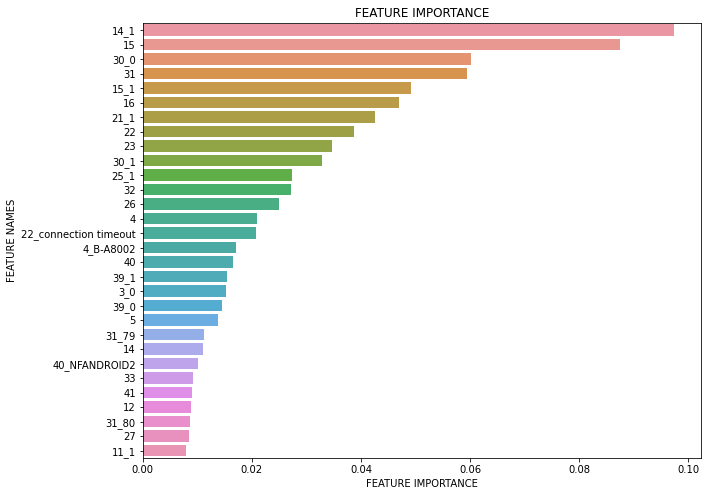

In [54]:
plot_feature_importance(forest.feature_importances_, data2.columns.difference(['have_quality']))

##### 펌웨어 업데이트와 23번 에러 일어난 시점

In [389]:
# 모델 2개 쓴 유저 drop
user_model_2 = []
for n,g in train_err.groupby(["user_id"]):
    if len(g["model_nm"].unique()) > 1 :
        user_model_2.extend(g.index.tolist())

In [390]:
train_err1 = train_err.drop(user_model_2)

In [391]:
train_err1["errtype_code"] = train_err1["errtype"].astype("str") + "_" + train_err1["errcode"].astype("str")

In [392]:
train_err1

,user_id,time,model_nm,fwver,errtype,errcode,days,hour,errtype_code
0,10000,20201101025616,model_3,05.15.2138,15,1,1,2,15_1
1,10000,20201101030309,model_3,05.15.2138,12,1,1,3,12_1
2,10000,20201101030309,model_3,05.15.2138,11,1,1,3,11_1
3,10000,20201101050514,model_3,05.15.2138,16,1,1,5,16_1
4,10000,20201101050515,model_3,05.15.2138,4,0,1,5,4_0
...,...,...,...,...,...,...,...,...,...
16554658,24999,20201130163051,model_3,05.15.2138,15,1,30,16,15_1
16554659,24999,20201130172625,model_3,05.15.2138,16,1,30,17,16_1
16554660,24999,20201130172625,model_3,05.15.2138,4,0,30,17,4_0
16554661,24999,20201130172631,model_3,05.15.2138,4,0,30,17,4_0


In [393]:
def find_fw_update(data):
    change_time=[]
    change_time_index = []
    for n,g in tqdm(temp.groupby(["user_id"])):
        if len(g["fwver"].unique()) > 1 :
            for i in g["fwver"].unique():
                is_fwver = g[g["fwver"] == i]
                change_index = is_fwver.index.tolist()[0]
                change_time_index.append(change_index)
                change_time.append(is_fwver["time"][change_index])
                #print(is_fwver.loc[change_index,"time"])
    return change_time, change_time_index

In [394]:
def plot_fw_errcode(data, c_t):
    # 23 25
    co_23 = data[data.errtype==23].errcode.unique()
    co_25 = data[data.errtype==25].errcode.unique()

    plt.figure(figsize=(20,8))   
    plt.scatter(c_t, np.zeros(len(c_t)), label = "fw")

    
    for i in range(len(co_23)):
        col = str(23)+"_"+co_23[i]
        plt.scatter(data[data.errtype_code == col].time, np.ones(len(data[data.errtype_code == col].time)) + i ,label = col)
        
    for i in range(len(co_25)):
        col = str(25)+"_"+co_25[i]
        plt.scatter(data[data.errtype_code == col].time, np.ones(len(data[data.errtype_code == col].time)) + i+len(co_23) ,label = col)
    plt.title(data.user_id.unique())
    plt.legend()
    plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.28it/s]


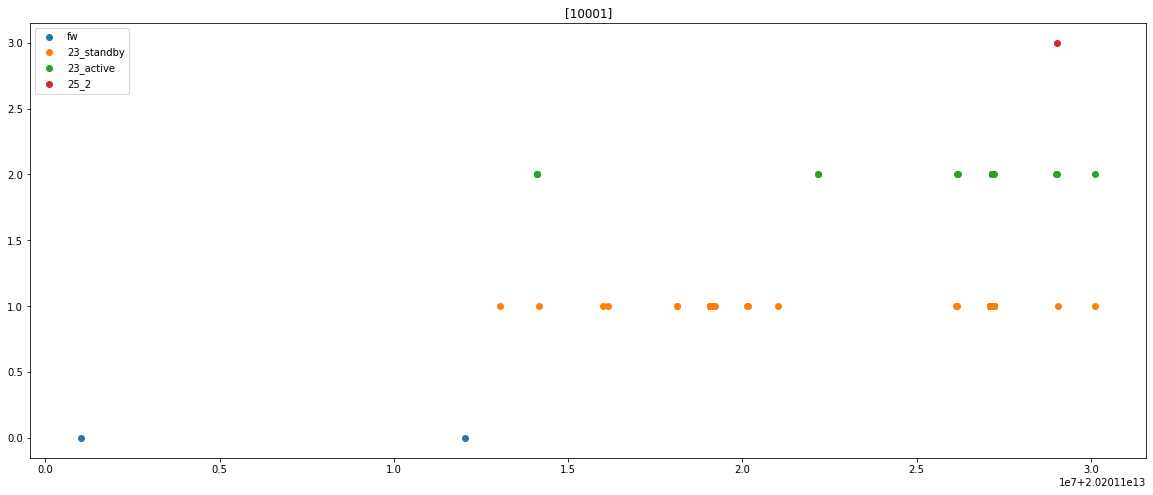

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


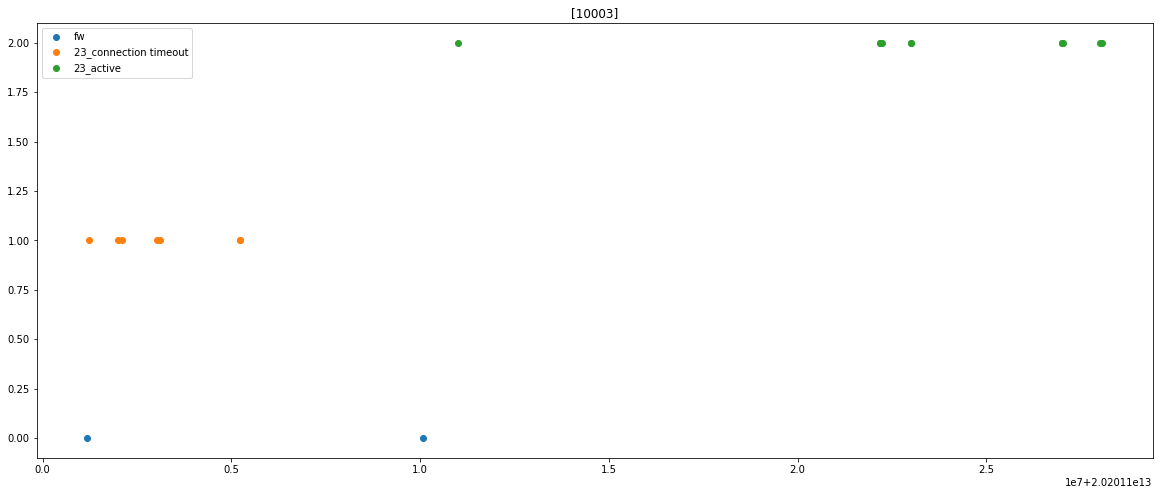

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.25it/s]


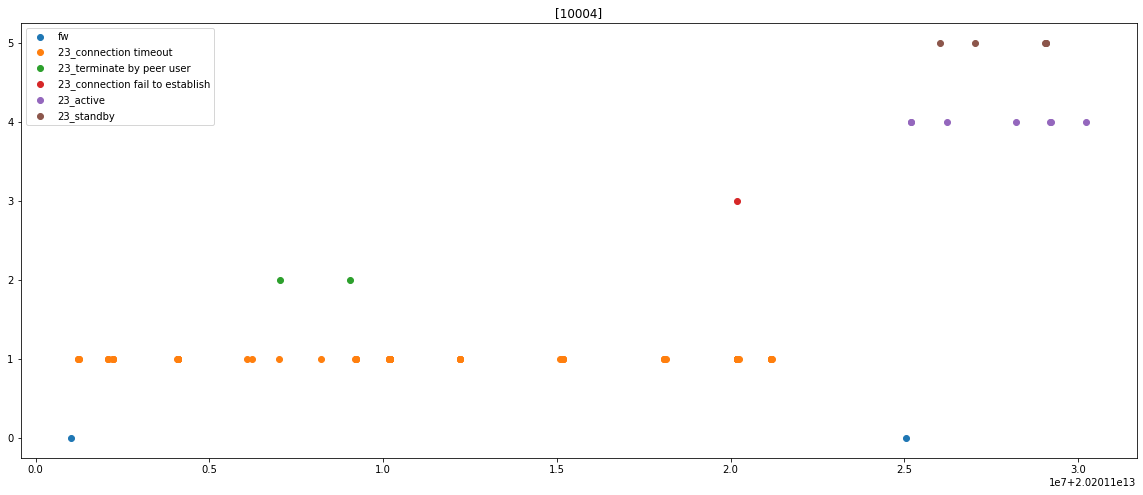

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.25it/s]


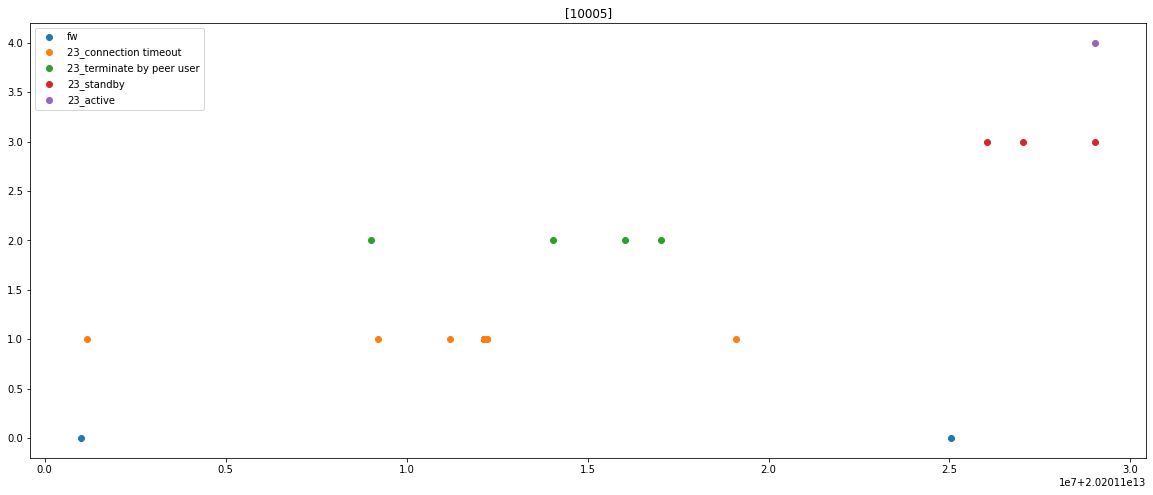

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.98it/s]


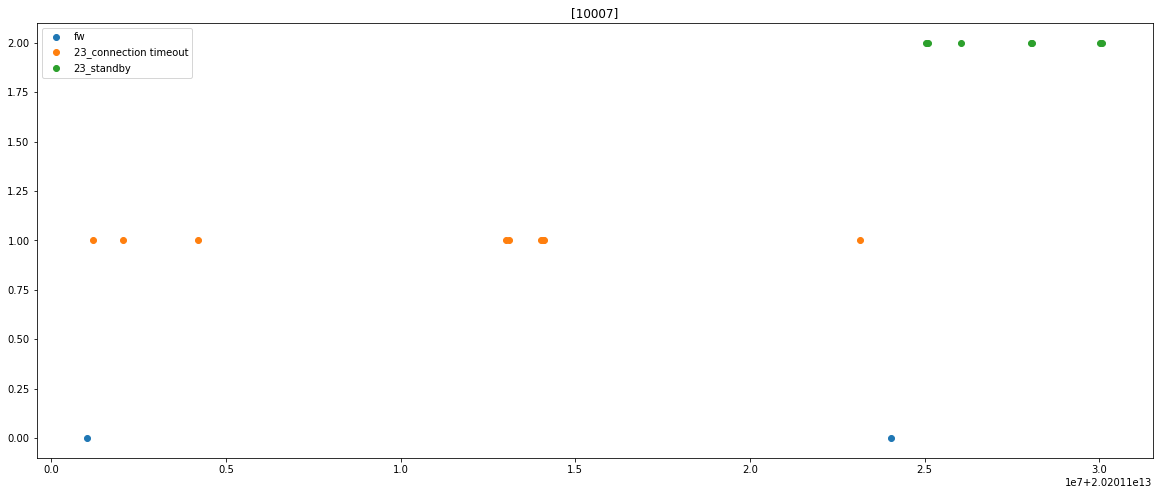

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 500.04it/s]


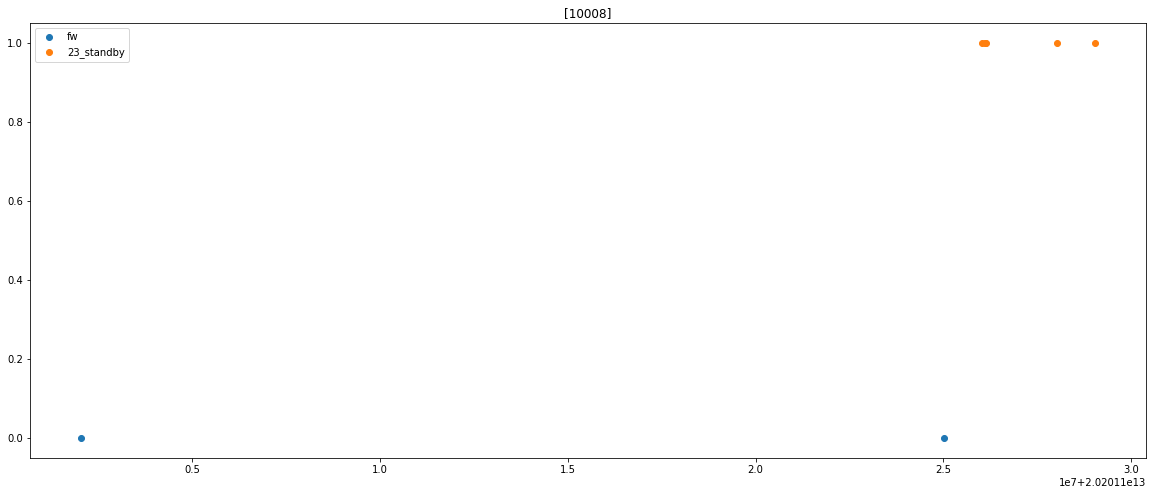

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.80it/s]


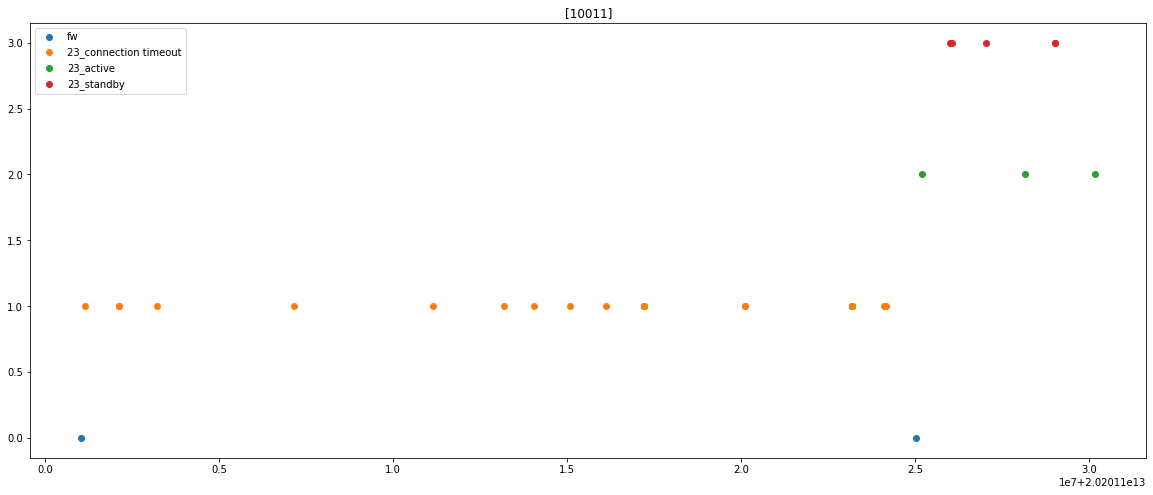

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 333.25it/s]


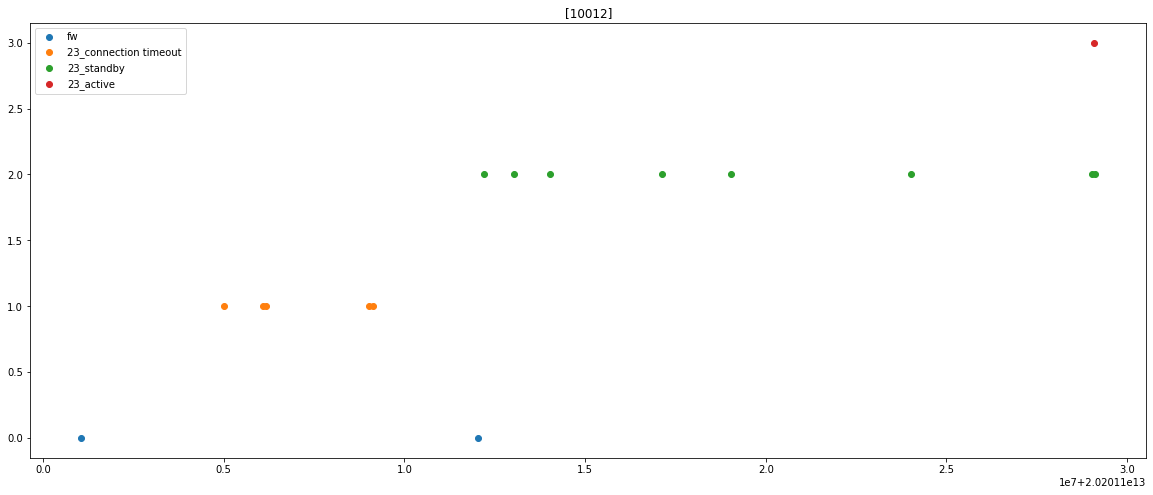

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 249.97it/s]


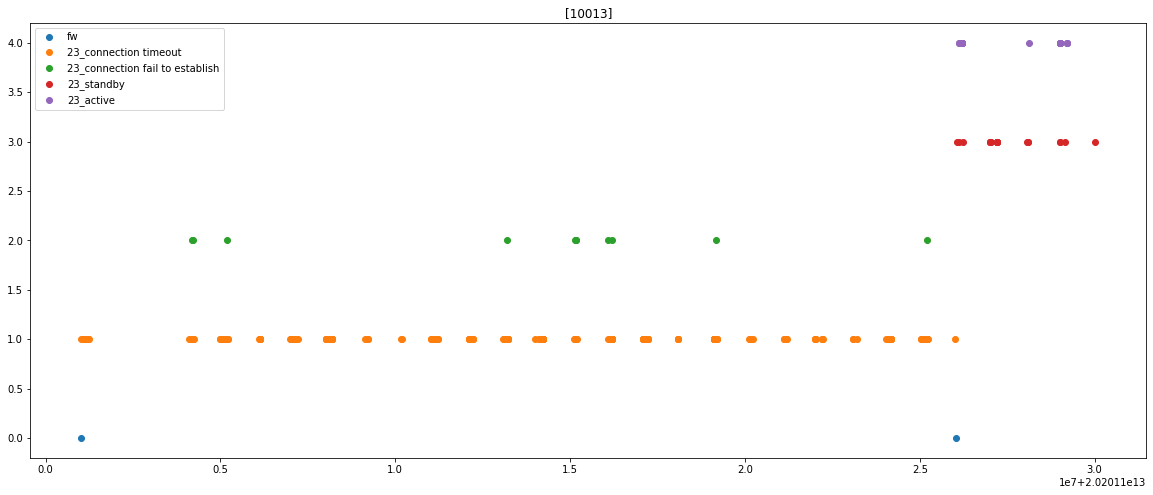

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


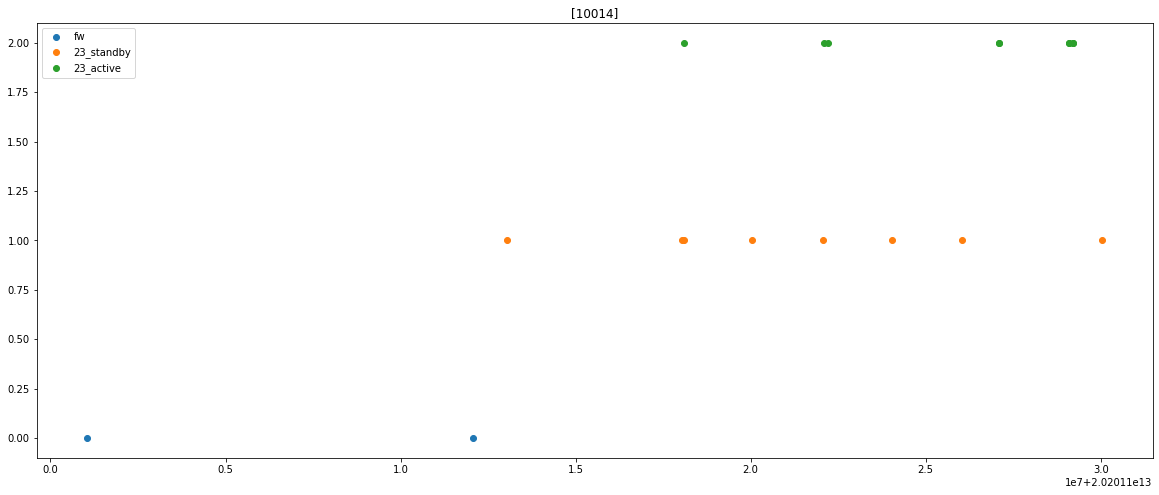

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


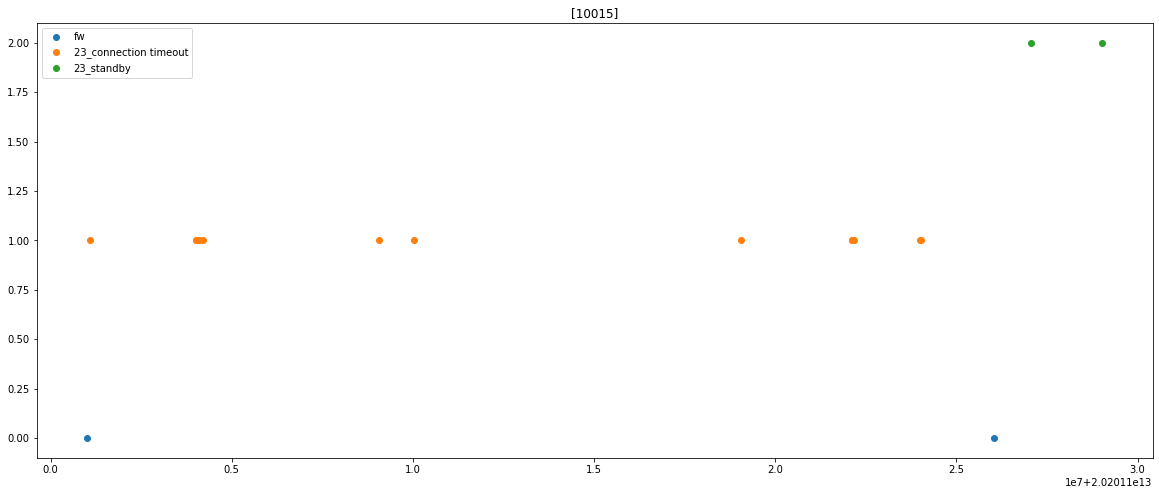

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.86it/s]


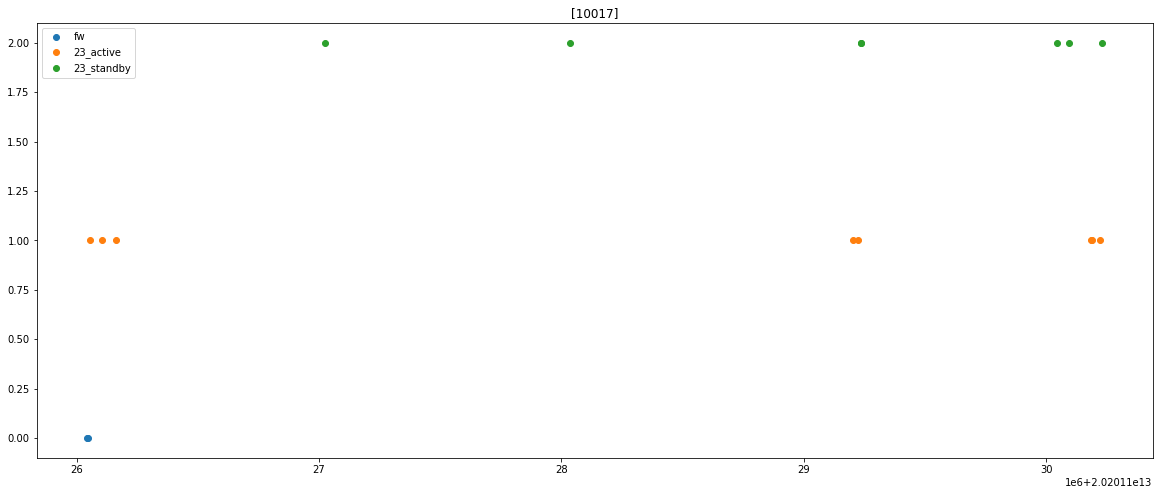

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 499.74it/s]


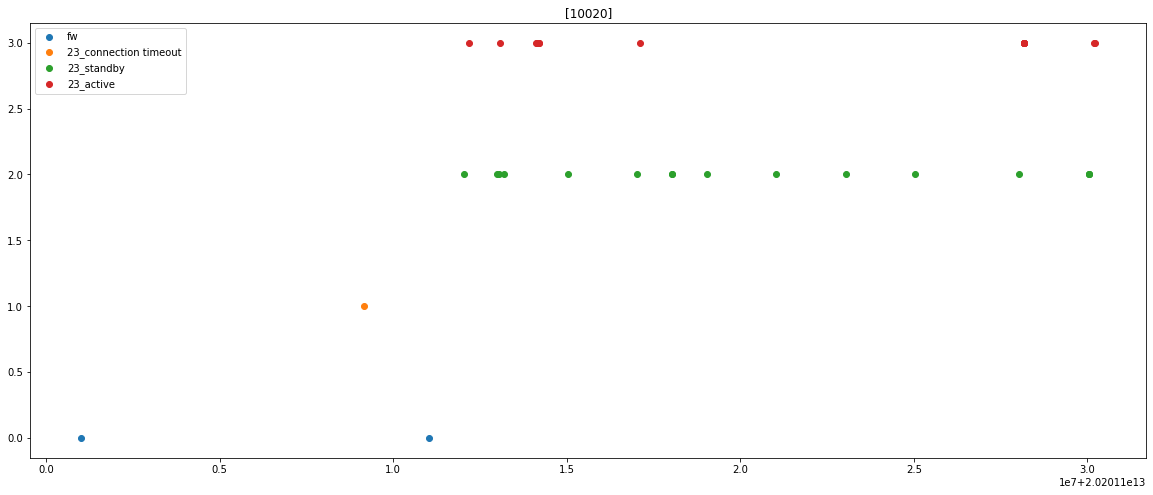

In [395]:
for i in range(20):
    temp = train_err1[train_err1.user_id.isin([train_err1.user_id.unique()[i]])]
    change_time, change_index = find_fw_update(temp)
    
    if len(change_time) > 0 :
        plot_fw_errcode(temp, change_time)

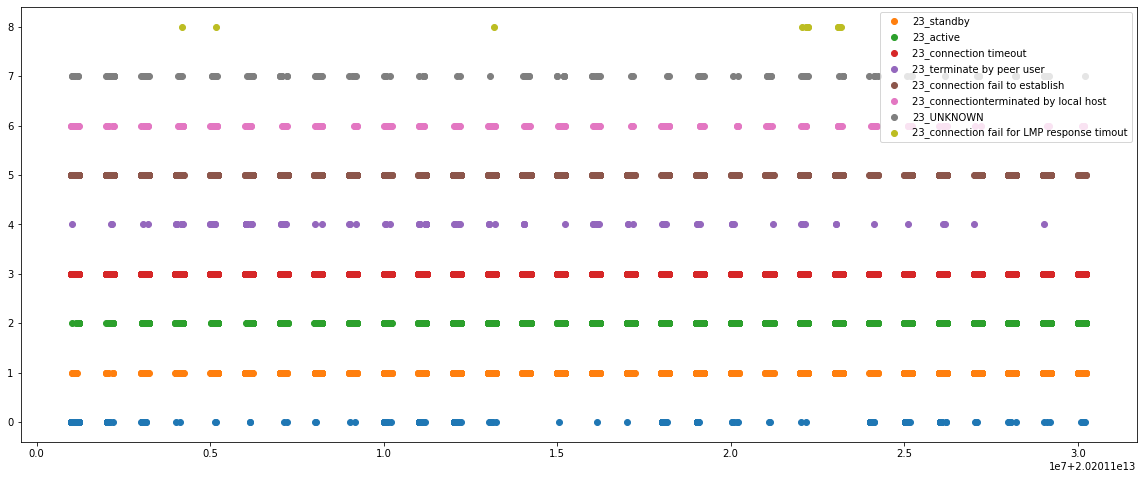

In [367]:
### 전체

In [29]:
clf = setup(data = data, numeric_features = list(data.columns.difference(['have_quality'])), target = 'have_quality') 

,Description,Value
0,session_id,2154
1,Target,have_quality
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(137794, 204)"
5,Missing Values,False
6,Numeric Features,203
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [30]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.8246,0.8796,0.6964,0.9352,0.7983,0.6489,0.6711
1,0.8311,0.8885,0.7043,0.9424,0.8061,0.6620,0.6841
2,0.8232,0.8837,0.6929,0.9360,0.7963,0.6462,0.6691
3,0.8336,0.8841,0.7107,0.9411,0.8098,0.6670,0.6878
4,0.8321,0.8884,0.7090,0.9391,0.8080,0.6639,0.6846
5,0.8344,0.8906,0.7080,0.9463,0.8100,0.6686,0.6908
6,0.8356,0.8948,0.7167,0.9390,0.8129,0.6709,0.6904
7,0.8378,0.8935,0.7146,0.9471,0.8146,0.6754,0.6967
8,0.8313,0.8915,0.7094,0.9368,0.8074,0.6624,0.6827
9,0.8288,0.8862,0.6938,0.9491,0.8016,0.6574,0.6824


In [31]:
pred_holdout = predict_model(lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.8326,0.8904,0.7121,0.9410,0.8107,0.6657,0.6866


In [32]:
clf = setup(data = data, numeric_features = list(data.columns.difference(['problem'])), target = 'problem') 

,Description,Value
0,session_id,8217
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0: 0, 1: 1"
4,Original Data,"(137794, 204)"
5,Missing Values,False
6,Numeric Features,203
7,Categorical Features,0
8,Ordinal Features,False
9,High Cardinality Features,False


In [33]:
lgbm = create_model('lightgbm')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.9770,0.6419,0.0045,0.2500,0.0089,0.0081,0.0310
1,0.9766,0.6352,0.0045,0.1250,0.0088,0.0072,0.0197
2,0.9769,0.6246,0.0182,0.3636,0.0346,0.0325,0.0771
3,0.9771,0.6121,0.0045,0.3333,0.0090,0.0084,0.0367
4,0.9769,0.6504,0.0091,0.2857,0.0176,0.0162,0.0475
5,0.9773,0.6560,0.0183,0.5000,0.0352,0.0337,0.0923
6,0.9769,0.6624,0.0136,0.3333,0.0262,0.0245,0.0636
7,0.9772,0.6575,0.0182,0.5000,0.0351,0.0335,0.0921
8,0.9773,0.6596,0.0182,0.5714,0.0352,0.0339,0.0990
9,0.9768,0.6212,0.0000,0.0000,0.0000,-0.0008,-0.0031


In [34]:
pred_holdout = predict_model(lgbm)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Light Gradient Boosting Machine,0.9780,0.6446,0.0078,0.2692,0.0152,0.0140,0.0426


In [ ]:
# 일단 여기까지

In [85]:
train_full.duplicated()

KeyboardInterrupt: 

In [8]:
# 사용되지 않는 타입_코드 칼럼을 제거
#train_test = pd.concat([train_full, test], axis=0)
select_columns = []
for c in tqdm(train_full.columns):
    try:
        if train_full[c].apply(lambda x: 1 if x > 0 else 0).sum() >= 20 and test[c].apply(lambda x: 1 if x > 0 else 0).sum() >= 20: # 트레이닝, 테스트 세트에 50개 이상의 행이 있어야함
            select_columns.append(c)
    except:
        print(c)
        break
        
print(len(columns), '개의 칼럼을', len(select_columns), '개로 압축')
train_full = train_full[select_columns]
test = test[select_columns]
columns = select_columns

100%|███████████████████████████████████████████████████████████████████████████| 64681/64681 [05:45<00:00, 187.24it/s]


6426 개의 칼럼을 1028 개로 압축


In [9]:
train_prob = pd.read_csv(PATH+'train_problem_data.csv')
problem = np.zeros(15000)
problem[train_prob.user_id.unique()-10000] = 1 
train_full['problem'] = problem

In [10]:
# train_full 전부 섞어주기
train_full = train_full.iloc[np.random.RandomState(seed=42).permutation(train_full.index)].reset_index(drop=True)
train_full = train_full.iloc[np.random.RandomState(seed=42).permutation(train_full.index)].reset_index(drop=True)

In [11]:
org_train_full = train_full
pearson_table = train_full.corr(method='pearson')
pearson = []
for i in train_full.columns:
    for j in train_full.columns:
        if (i >= j):
            continue
        pearson.append((i,j,pearson_table.loc[i,j]))
pearson = sorted(pearson, key=lambda x: abs(x[2]), reverse=True)

In [12]:
remove_columns = set()
fix_columns = set()
for i in pearson:
    # 이미 제거되었으면 넘기기
    if (i[0] in remove_columns or i[1] in remove_columns):
        continue
    if (abs(i[2]) >= 0.9999):
        remove_columns.add(i[0])

print(len(train_full.columns), '개의 칼럼을', len(train_full.columns) - len(remove_columns), '개로 압축')
#0.9999
#train_full = train_full[train_full.columns.difference(list(remove_columns))]

1029 개의 칼럼을 880 개로 압축


In [13]:
#train_full 데이터를 train, valid로 나눔 (valid는 점수 검증용으로)
def make_train_val(data, r=0.8):
    min_user_id = data.index.min()
    max_user_id = data.index.max()
    m = int((1 - r) * min_user_id + r * max_user_id)
    return data.loc[data.index < m], data.loc[data.index >= m]

train, valid = make_train_val(train_full)

In [14]:
NFOLD = 10
folds = StratifiedKFold(n_splits=NFOLD, shuffle=True, random_state=42)

In [15]:
def reset_bad_features():
    global bad_features
    bad_features = []
    for i in range(0, NFOLD):
        bad_features.append([])
        
def add_bad_features(index, col):
    for i in index:
        bad_features[i].append(col)
        bad_features[i] = list(set(bad_features[i]))
    
def set_bad_features(perms, bad_feature_threshold):
    global bad_features
    for i in range(0, len(r['perms'])):
        col = train.columns.difference(['problem'] + bad_features[i])
        b_columns = pd.DataFrame(col, columns=['column'])
        b_columns['score'] = r['perms'][i].feature_importances_
        b_columns = b_columns.loc[b_columns['score'] < bad_feature_threshold]['column'].values
        bad_features[i].extend(b_columns)
        bad_features[i] = list(set(bad_features[i])) # 혹시 모를 칼럼 중복 제거

In [16]:
# LBGM 
class AUCLGBMScorerWrapper(object):
    """Base class"""
    def fit(self, X, y):
        print('F1MacroScorerWrapper fit called!')
    def train(self, **kwargs):
        self.model = lgb.train(**kwargs)
        return self
    
    def predict(self, X):
        return self.model.predict(X)

    def score(self, X, y):
        val_pred = self.model.predict(X)
        auc_score = roc_auc_score(y, val_pred)
        return auc_score
    

In [17]:
def reset_fold_cache():
    global fold_cache
    fold_cache = {}
reset_fold_cache()

In [18]:
from sklearn.ensemble import RandomForestClassifier
from eli5.sklearn import PermutationImportance
from imblearn.over_sampling import SMOTE

def lgbm_train(data, params = {}, out_perm = True, random_state=42, fold_cache_name=None, valid=valid):
    params['seed'] = 1015
    params['metric'] = 'auc'
    params['objective'] = 'binary'
    params['verbose'] = -1
    perms = []
    auc_scores = []
    test_pred = []
    fold = 0
    # smote를 이용해서 데이터 불균형 해소
    smote = SMOTE(random_state=random_state)
    if 'boosting_list' in params:
        temp = params['boosting_list']
        for i in temp.keys():
            params[i] = temp[i]
        del(params['boosting_list'])
    int_params = ['max_depth', 'num_leaves', 'num_iterations', 'min_data_in_leaf', 'max_bin', 'min_data_in_bin']
    for i in int_params:
        if i in params:
            params[i] = int(params[i])
    models = []
    
    # smote 알고리즘이 오래 걸리니까 한번 사용한걸 캐시로 저장
    if (fold_cache_name, random_state, str(bad_features)) not in fold_cache or fold_cache_name == None:
        i = 0
        temp = []
        for train_idx, val_idx in folds.split(data, data['problem']):
            # print(bad_features[0])
            train_x = data.loc[train_idx][data.columns.difference(['problem'] + bad_features[i])]
            train_y = data.loc[train_idx]['problem']
            valid_x = data.loc[val_idx][data.columns.difference(['problem'] + bad_features[i])]
            valid_y = data.loc[val_idx]['problem']

            train_x, train_y = smote.fit_sample(train_x, train_y)
            temp.append({'train_x': train_x,'train_y': train_y, 'valid_x': valid_x, 'valid_y': valid_y})
            i += 1
        fold_cache[fold_cache_name, random_state, str(bad_features)]  = temp
            
    for i in range(0,NFOLD):
        train_x = fold_cache[fold_cache_name, random_state, str(bad_features)][i]['train_x']
        train_y = fold_cache[fold_cache_name, random_state, str(bad_features)][i]['train_y']
        valid_x = fold_cache[fold_cache_name, random_state, str(bad_features)][i]['valid_x']
        valid_y = fold_cache[fold_cache_name, random_state, str(bad_features)][i]['valid_y']
        
        d_train = lgb.Dataset(train_x, train_y, silent=True, free_raw_data=False, params={'verbose': -1})
        d_val  = lgb.Dataset(valid_x, valid_y, silent=True, free_raw_data=False, params={'verbose': -1})
        test_x = valid.loc[:, valid.columns.difference(['problem'] + bad_features[i])]

        clf = AUCLGBMScorerWrapper().train(params=params, train_set=d_train, valid_sets=[d_train, d_val],  verbose_eval=False, early_stopping_rounds=200)
        val_pred = clf.predict(valid_x)
        auc_score = roc_auc_score(valid_y, val_pred)
        auc_scores.append(auc_score)
        test_pred.append(clf.predict(test_x))
        if out_perm:
            perm = PermutationImportance(clf, random_state = 42, n_iter = 10).fit(valid_x, valid_y)
            perms.append(perm)
        models.append(clf)

    pred_ensemble = np.mean(test_pred, axis = 0)
    score = roc_auc_score(valid.loc[:, ['problem']], pred_ensemble)
    return {'models': models, 'perms': perms, 'auc': np.mean(auc_scores), 'test auc': score}

In [19]:
def global_score(params = {}, fold_cache_name='fold_cache_name'):
    #folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    scores = []
    i = 0
    for train_idx, val_idx in folds.split(train_full, train_full['problem']):
        train_full.loc[val_idx]
        if fold_cache_name == None:
            name = None
        else:
            name = fold_cache_name + str(i)
            
        scores.append(lgbm_train(train_full.loc[train_idx].reset_index(), params=params, out_perm=False, fold_cache_name= name, valid=train_full.loc[val_idx].reset_index())['test auc'])
        i += 1
    return np.mean(scores)

In [20]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials
def find_hyper_params(max_evals=10):
    boosting_list = [
        {'boosting': 'gbdt'},
        {'boosting': 'goss', 'top_rate': hp.uniform('top_rate', 0, 0.5), 'other_rate': hp.uniform('other_rate', 0, 0.5)}
    ]

    search_space = {
            'boosting_list' : hp.choice('boosting_list', boosting_list),
            'num_iterations': hp.quniform("num_iterations", 100, 5000, 100),
            'max_depth':  hp.quniform("max_depth", 2, 25, 1),
            'max_bin': hp.quniform('max_bin', 32, 255, 1),

            'min_data_in_leaf': hp.quniform('min_data_in_leaf', 1, 256, 1),
            'min_data_in_bin': hp.quniform('min_data_in_bin', 1, 256, 1),
            'min_gain_to_split' : hp.quniform('min_gain_to_split', 0.1, 5, 0.01),

            'lambda_l1' : hp.uniform('lambda_l1', 0, 5),
            'lambda_l2' : hp.uniform('lambda_l2', 0, 5),
            'num_leaves':  hp.quniform("num_leaves", 2, 100, 1),
            'learning_rate': hp.loguniform('learning_rate', -5, 0),

                    'feature_fraction' : hp.quniform('feature_fraction', 0.5, 1, 0.01),
                    'bagging_fraction' : hp.quniform('bagging_fraction', 0.5, 1, 0.01)
    }

    trials = Trials()
    best=fmin(fn=lambda x: -global_score(x), # function to optimize
              space=search_space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=max_evals, # maximum number of iterations
              trials=trials, # logging
              rstate=np.random.RandomState(42) # fixing random state for the reproducibility
             )
                               

    best['boosting'] = boosting_list[best['boosting_list']]['boosting']
    del(best['boosting_list'])
    return best



In [21]:
# 기본 성능 테스트
import eli5
reset_bad_features()
r = lgbm_train(train, out_perm=False, fold_cache_name='train')
print("deafult CV - AUC", r['auc'])
print("deafult Test - AUC", r['test auc'])
print("global AUC", global_score())
# r = lgbm_train(train, out_perm=True, fold_cache_name='train')
#eli5.show_weights(r['perms'][3], top = 30, feature_names = train.columns.difference(['problem']).tolist())

deafult CV - AUC 0.8245717922551972
deafult Test - AUC 0.8397601172494242
global AUC 0.832363


In [21]:
# 기본 성능 테스트
import eli5
reset_bad_features()
r = lgbm_train(train, out_perm=False, fold_cache_name='train')
print("deafult CV - AUC", r['auc'])
print("deafult Test - AUC", r['test auc'])
print("global AUC", global_score())
# r = lgbm_train(train, out_perm=True, fold_cache_name='train')
#eli5.show_weights(r['perms'][3], top = 30, feature_names = train.columns.difference(['problem']).tolist())

deafult CV - AUC 0.8241421928421435
deafult Test - AUC 0.8403501031914575
global AUC 0.8320547999999999


In [25]:
# 0~42번 컬럼 제거
import eli5

reset_bad_features()
for i in range(0,42):
    add_bad_features(range(0,NFOLD), 'sum_'+str(i))
    add_bad_features(range(0,NFOLD), 'std_'+str(i))
    add_bad_features(range(0,NFOLD), 'max_'+str(i))
    for q in global_parameters['quantile']:
        add_bad_features(range(0,NFOLD), str(int(q * 100)) + '_' + str(i))
        
for i in train_full.columns:
    if i.startswith('75_'):
        1#add_bad_features(range(0,10), i)
    
r = lgbm_train(train, out_perm=False, fold_cache_name='train')
print("deafult CV - AUC", r['auc'])
print("deafult Test - AUC", r['test auc'])
print("global AUC", global_score())

# r = lgbm_train(train, out_perm=True, fold_cache_name='train')
#eli5.show_weights(r['perms'][3], top = 30, feature_names = train.columns.difference(['problem']).tolist())

deafult CV - AUC 0.8230021035290512
deafult Test - AUC 0.8386541740196812
global AUC 0.8314956


In [29]:
def t(q):
    reset_bad_features()
    '''
    for i in range(0,42):
        add_bad_features(range(0,NFOLD), 'sum_'+str(i))
        add_bad_features(range(0,NFOLD), 'std_'+str(i))
        add_bad_features(range(0,NFOLD), 'max_'+str(i))
        for q in global_parameters['quantile']:
            add_bad_features(range(0,NFOLD), str(int(q * 100)) + '_' + str(i))
    '''
    for j in q:
        for i in train_full.columns:
            if i.startswith(str(j) + '_'):
                add_bad_features(range(0,10), i)
    
    r = lgbm_train(train, out_perm=False, fold_cache_name='train')
    print("q", q)
    print("deafult CV - AUC", r['auc'])
    print("deafult Test - AUC", r['test auc'])
    print("global AUC", global_score())

# r = lgbm_train(train, out_perm=True, fold_cache_name='train')
#eli5.show_weights(r['perms'][3], top = 30, feature_names = train.columns.difference(['problem']).tolist())

In [30]:
t([70])
t([80])
t([70,80])
t([70,75])
t([75,80])

q [70]
deafult CV - AUC 0.8245717922551972
deafult Test - AUC 0.8397601172494242
global AUC 0.832363
q [80]
deafult CV - AUC 0.8247603168418667
deafult Test - AUC 0.8396075733556666
global AUC 0.8321086
q [70, 80]
deafult CV - AUC 0.8230479580779353
deafult Test - AUC 0.8393039810965215
global AUC 0.8322071999999998
q [70, 75]
deafult CV - AUC 0.825027109649025
deafult Test - AUC 0.838217728990319
global AUC 0.8321542
q [75, 80]
deafult CV - AUC 0.8240752129944477
deafult Test - AUC 0.8384121476784414
global AUC 0.8319989999999999


In [31]:
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials, SparkTrials
find_bad_features_result = []
def _bad_features_process(columns_param):
    inactive_statistics = []
    inactive_error = []
    for i in columns_param:
        if i.startswith('statistics_') and columns_param[i]:
            key = i.replace('statistics_', '')
            inactive_statistics.append(key)
        if i.startswith('error_') and columns_param[i]:
            key = i.replace('error_', '')
            inactive_error.append(key)
    reset_bad_features()
    for i in inactive_statistics:
        for j in inactive_error:
            # 없는 칼럼일수도 있음 (앞에서 압축 과정에서 사라진 컬럼)
            add_bad_features(range(0,NFOLD), i + '_'+ j)
    score = global_score(fold_cache_name=None)
    find_bad_features_result.append([score, columns_param])
    return -score

def find_bad_features(max_evals=10):
    remove_search_space = {}
    for i in ['sum', 'std', 'max', '10', '25', '50', '75', '90', '95']:
        key = 'statistics_' + i
        remove_search_space[key] = hp.choice(key, [False,True])
        
    for i in train_full.columns.difference(['problem']):
        if i.startswith('sum_') == False:
            continue
        key = 'error_' + i.replace('sum_', '')
        remove_search_space[key] = hp.choice(key, [True])
    
    trials = Trials()
    best=fmin(fn=_bad_features_process, # function to optimize
              space=remove_search_space, 
              algo=tpe.suggest, # optimization algorithm, hyperotp will select its parameters automatically
              max_evals=max_evals, # maximum number of iterations
              trials=trials, # logging
              rstate=np.random.RandomState(42) # fixing random state for the reproducibility
             )
                  

In [32]:
find_bad_features(500)

  2%|▋                                          | 8/500 [57:38<59:05:09, 432.34s/trial, best loss: -0.8309148000000001]



KeyboardInterrupt



In [69]:
# 옵션 1) 하이퍼 파라미터 튜닝
reset_bad_features()
for i in range(0,42):
    add_bad_features(range(0,10), str(i))

best_params = find_hyper_params(300)
r = lgbm_train(train, params=best_params, out_perm=False, fold_cache_name='train')
print("hyperopt CV - AUC", r['auc'])
print("hyperopt Test - AUC", r['test auc'])

  0%|                                                                          | 0/300 [00:30<?, ?trial/s, best loss=?]


KeyboardInterrupt: 

In [26]:
reset_bad_features()
r = lgbm_train(train, out_perm=True, fold_cache_name='train')

In [27]:
# 옵션 2) 불필요한 컬럼 제거
sample = [0, 0.00005, 0.00006, 0.00007, 0.00008,0.00009, 0.0001,0.00015, 0.0002,0.00025, 0.0003,0.00035, 0.0004, 0.0005, 0.0001, 0.0030, 0.006, 0.01]
for s in sample:
    reset_bad_features()
    set_bad_features(r['perms'], s)
    sample_result = lgbm_train(train, out_perm=False)
    
    print("cut_off", s)
    print("bad_features 개수", [len(i) for i in bad_features])
    print("CV - AUC", sample_result['auc'])
    print("Test - AUC", sample_result['test auc'])
    print("global AUC", global_score())
    print("----------------------------------------------------")

cut_off 0
bad_features 개수 [99, 85, 80, 92, 102, 103, 88, 116, 95, 85]
CV - AUC 0.8230029762457212
Test - AUC 0.8364844116092883
global AUC 0.830504
----------------------------------------------------
cut_off 5e-05
bad_features 개수 [345, 336, 326, 343, 344, 346, 337, 355, 342, 342]
CV - AUC 0.82730300444561
Test - AUC 0.8364869041565719
global AUC 0.8313032
----------------------------------------------------
cut_off 6e-05
bad_features 개수 [349, 341, 329, 345, 348, 353, 341, 359, 343, 346]
CV - AUC 0.826014005761419
Test - AUC 0.8365821194628063
global AUC 0.8306312
----------------------------------------------------
cut_off 7e-05
bad_features 개수 [355, 342, 334, 347, 349, 356, 345, 363, 345, 350]
CV - AUC 0.825262443533244
Test - AUC 0.8372122354161058
global AUC 0.8313233999999999
----------------------------------------------------
cut_off 8e-05
bad_features 개수 [358, 344, 335, 350, 352, 357, 348, 367, 348, 356]
CV - AUC 0.8258362234775062
Test - AUC 0.8374250989541272
global AUC 0.831

In [ ]:
# cutoff 지정
reset_bad_features()
set_bad_features(r['perms'], 0.0003)
sample_result = lgbm_train(train, out_perm=False)
print("bad_features 개수", [len(i) for i in bad_features])
print("CV - AUC", sample_result['auc'])
print("Test - AUC", sample_result['test auc'])


In [43]:
reset_bad_features()
for i in range(0,42):
    add_bad_features(range(0,10), 'sum_'+str(i))
    add_bad_features(range(0,10), 'std_'+str(i))
    add_bad_features(range(0,10), 'max_'+str(i))
    add_bad_features(range(0,10), '25_'+str(i))
    add_bad_features(range(0,10), '50_'+str(i))
    add_bad_features(range(0,10), '75_'+str(i))

In [29]:
def submit(boostmodel):
    pred_y_list = []
    for i in range(0, len(boostmodel)):
        model = boostmodel[i]
        pred_y = model.predict(test[test.columns.difference(['problem'] + bad_features[i])])
        pred_y_list.append(pred_y.reshape(-1,1))

    pred_ensemble = np.mean(pred_y_list, axis = 0)
    return pred_ensemble
        
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = submit(lgbm_train(train_full, out_perm=False)['models'])
sample_submssion.to_csv("LGBM (std,max,25,50,75).csv", index = False)

In [ ]:
'''
data = train
c = data.columns.difference(['problem', 'user_id'])
def mul_table(org, columns):
    table = org.copy()
    for i in c:
        for j in c:
            if (i == j):
                continue
            if (i < j):
                table[str(i) + '*' + str(j)] = table.loc[i] * table[j]
            
            # table[str(i) + '/' + str(j)] = table[i] / (table[j] + 1)
                
                
    return table
data = mul_table(data,c)
'''

In [62]:
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
#scaler = StandardScaler()
#data.loc[:,:] = scaler.fit_transform(data)
#train_x = scaler.transform(train_x)
#test_x = scaler.transform(test_x)
data = train_full
train_p = data.loc[data['problem'] == 1, data.columns != 'problem']
train_np = data.loc[data['problem'] == 0, data.columns != 'problem']

In [63]:
def divide_list(l, n): 
    # 리스트 l의 길이가 n이면 계속 반복
    for i in range(0, len(l), n): 
        yield l[i:i + n] 
# 한 리스트에 몇개씩 담을지 결정
n = 20
divided_columns = list(divide_list(train_full.columns, n))

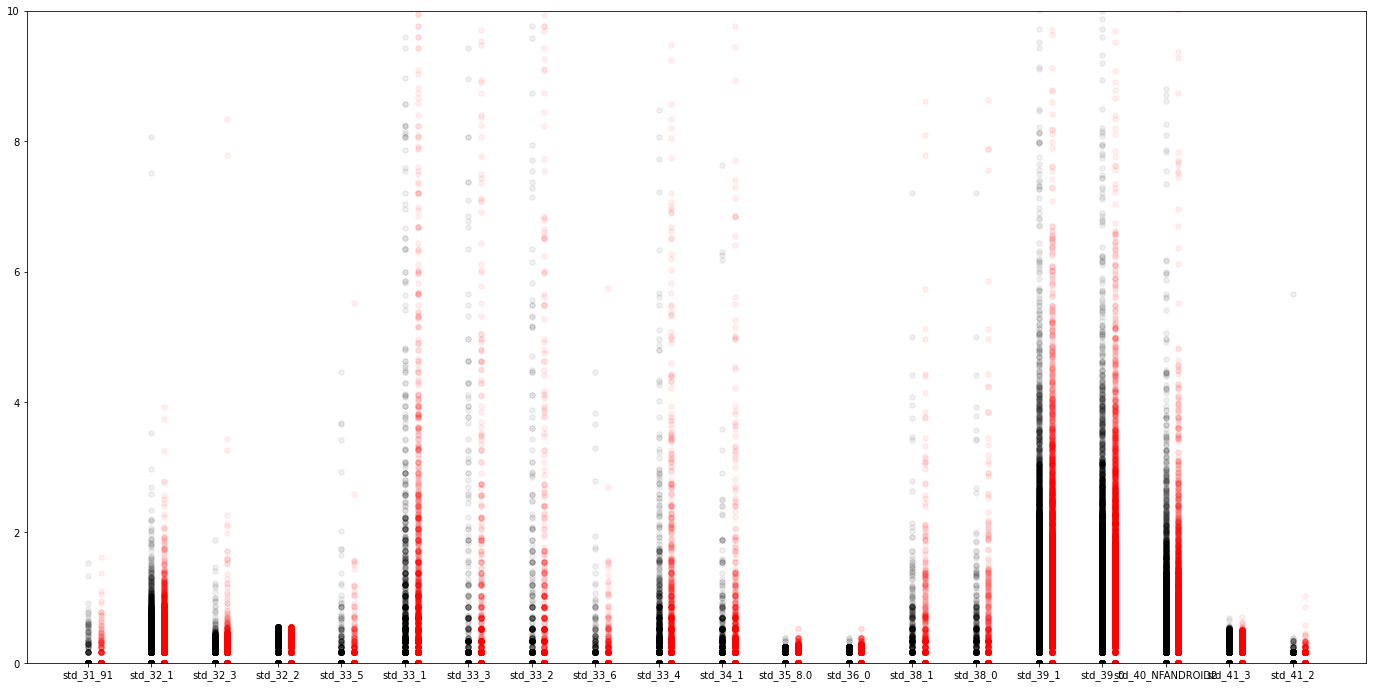

In [66]:
view_columns = divided_columns[15]

plt.figure(figsize=(24,12))
plt.xticks(list(range(len(view_columns))), labels=view_columns)
plt.ylim(0,10)
i = 0
for c in view_columns:
    plt.scatter([i] * len(train_np), train_np[c], linewidth=1, color="#00000010", s=30)
    plt.scatter([i + 0.2] * len(train_p), train_p[c], linewidth=1, color="#ff000010", s=30)
    
    i += 1
    

In [49]:
clf = setup(data = train_full[train_full.columns.difference(bad_features[0])], target = 'problem', normalize = False, feature_interaction = False, feature_ratio = False, polynomial_features=False, feature_selection=False, feature_selection_threshold =0.9) 

,Description,Value
0,session_id,7835
1,Target,problem
2,Target Type,Binary
3,Label Encoded,"0.0: 0, 1.0: 1"
4,Original Data,"(15000, 508)"
5,Missing Values,False
6,Numeric Features,504
7,Categorical Features,3
8,Ordinal Features,False
9,High Cardinality Features,False


In [50]:
best_5 = compare_models(sort = 'Accuracy', n_select = 5)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
lightgbm,Light Gradient Boosting Machine,0.7939,0.8241,0.5422,0.7694,0.6357,0.4981,0.5131,0.1420
catboost,CatBoost Classifier,0.7938,0.8293,0.5271,0.7812,0.6291,0.4938,0.5123,7.6030
et,Extra Trees Classifier,0.7919,0.8198,0.5268,0.7749,0.6269,0.4899,0.5076,0.5620
gbc,Gradient Boosting Classifier,0.7899,0.8212,0.5010,0.7900,0.6129,0.4786,0.5021,1.0310
rf,Random Forest Classifier,0.7865,0.8172,0.5053,0.7741,0.6111,0.4730,0.4935,0.3040
xgboost,Extreme Gradient Boosting,0.7850,0.8121,0.5526,0.7353,0.6305,0.4833,0.4934,1.1210
ada,Ada Boost Classifier,0.7791,0.8049,0.4987,0.7533,0.5998,0.4560,0.4746,0.2530
lda,Linear Discriminant Analysis,0.7687,0.7769,0.4328,0.7705,0.5536,0.4141,0.4457,0.2950
ridge,Ridge Classifier,0.7671,0.0000,0.4168,0.7793,0.5424,0.4054,0.4413,0.0410
lr,Logistic Regression,0.7644,0.7763,0.4202,0.7646,0.5421,0.4012,0.4338,2.2760


CatBoost, Lightgbm, gbc, et,rf 가 골고루 AUC 0.8대를 보여주기 때문에 5개를 골라 블렌딩 해보겠습니다

In [51]:
blended = blend_models(estimator_list = best_5[0:3], fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7867,0.8394,0.5244,0.7593,0.6203,0.4788,0.4947
1,0.8038,0.8352,0.5587,0.7895,0.6544,0.5229,0.5382
2,0.8048,0.8383,0.5530,0.7975,0.6531,0.5234,0.5404
3,0.7876,0.8173,0.4900,0.7917,0.6053,0.4708,0.4962
4,0.7829,0.8098,0.4928,0.7713,0.6014,0.4620,0.4838
5,0.8105,0.8699,0.5616,0.8099,0.6633,0.5373,0.5548
6,0.8181,0.8504,0.5645,0.8347,0.6735,0.5539,0.5742
7,0.7848,0.8159,0.5158,0.7595,0.6143,0.4725,0.4895
8,0.8152,0.8467,0.5714,0.8197,0.6734,0.5502,0.5676
9,0.7674,0.7991,0.4728,0.7333,0.5749,0.4249,0.4443


In [53]:
blended2 = blend_models(estimator_list = best_5, fold = 10, method = 'soft')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,0.7829,0.8391,0.5072,0.7597,0.6082,0.4662,0.4844
1,0.8000,0.8340,0.5501,0.7837,0.6465,0.5129,0.5285
2,0.8067,0.8345,0.5330,0.8230,0.6470,0.5221,0.5455
3,0.7848,0.8155,0.4785,0.7915,0.5964,0.4616,0.4887
4,0.7733,0.8078,0.4642,0.7606,0.5765,0.4339,0.4585
5,0.8067,0.8677,0.5559,0.8017,0.6565,0.5280,0.5452
6,0.8143,0.8492,0.5530,0.8319,0.6644,0.5431,0.5647
7,0.7867,0.8153,0.4928,0.7854,0.6056,0.4697,0.4937
8,0.8133,0.8464,0.5600,0.8235,0.6667,0.5435,0.5630
9,0.7684,0.7987,0.4756,0.7345,0.5774,0.4277,0.4469


In [54]:
pred_holdout = predict_model(blended)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7827,0.8187,0.5123,0.7616,0.6125,0.4695,0.4873


In [55]:
pred_holdout = predict_model(blended2)

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
0,Voting Classifier,0.7818,0.8193,0.5089,0.7611,0.6100,0.4667,0.4849


In [56]:
final_model = finalize_model(blended)

In [57]:
predictions = predict_model(final_model, data = test)

In [58]:
#pycaret에서는 score이 label을 맞출 확률이기때문에 output을 제출 양식에 맞게 바꿔줍니다
x = []
for i in range(len(predictions['Score'])):
  if predictions['Label'][i] =='1.0':
    x.append(predictions['Score'][i])
  else:
    
    x.append(1-predictions['Score'][i])

In [59]:
predictions

,sum_0,sum_1,sum_2,sum_3,sum_4,sum_5,sum_6,sum_7,sum_8,sum_9,...,75_34_1,75_38_1,75_38_0,75_39_1,75_39_0,75_40_NFANDROID2,75_41_3,used_days,Label,Score
0,0.0,0.0,0.0,0.0,62.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,2.0,2.0,0.0,0.0,29.0,1.0,0.9229
1,0.0,0.0,3.0,98.0,3.0,4.0,4.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,28.0,0.0,0.6393
2,0.0,0.0,0.0,0.0,79.0,2.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,3.0,0.0,0.0,30.0,1.0,0.5204
3,0.0,0.0,0.0,0.0,107.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,0.0,0.0,28.0,1.0,0.8381
4,0.0,0.0,0.0,2.0,6.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,4.0,0.0,30.0,1.0,0.6924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14994,0.0,0.0,0.0,2.0,12.0,5.0,5.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,3.0,3.0,0.0,30.0,0.0,0.8466
14995,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,30.0,0.0,0.7354
14996,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,7.0,7.0,0.0,0.0,30.0,1.0,0.8283
14997,0.0,0.0,0.0,1.0,4.0,2.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,1.0,2.0,0.0,28.0,1.0,0.7740


In [60]:
sample_submssion = pd.read_csv(PATH+'sample_submission.csv')
sample_submssion['problem'] = x
sample_submssion.to_csv("AutoML_앞이랑 동일(fold=10, best_3, bad_feature 제거).csv", index = False)